# IPARO Implementation using IPFS

This notebook demonstrates a simple implementation of InterPlanetary Archival Record Objects (IPAROs) using IPFS. We'll create, store, and link IPAROs where a node only link to one prior node, and explore how to retrieve and navigate between them.

## Step 1: Prerequisites

- Install IPFS and ensure it's running on your system with:

   ```bash
   ipfs daemon
   ```

In [82]:
import json
import requests
import time
from datetime import datetime, UTC

# IPFS API URL
ipfs_api_url = 'http://127.0.0.1:5001/api/v0'

## Step 2: Define Functions for Creating and Storing IPAROs

We will define functions to create IPAROs, add them to IPFS, and update links between them.

In [83]:
def create_iparo(content: str, prev_cid=None) -> dict:
    """
    Create an IPARO with the given content and links to previous and next IPAROs.

    Args:
        content (str): The content of the IPARO.
        prev_cids (list): List of CIDs of the previous IPAROs.
        next_cid (str): CID of the next IPARO.

    Returns:
        dict: The created IPARO.
    """
    iparo = {
        'content': content,
        'prev_cid': prev_cid,
        'timestamp': datetime.now(UTC).isoformat()
    }
    return iparo


def add_to_ipfs(iparo: dict) -> str:
    """
    Add the given IPARO to IPFS and return its CID.

    Args:
        iparo (dict): The IPARO to add to IPFS.

    Returns:
        str: The CID of the added IPARO.
    """
    iparo_json = json.dumps(iparo)
    response = requests.post(f'{ipfs_api_url}/add', files={'file': iparo_json})
    cid = response.json()['Hash']
    return cid

## Step 3: Create function to link created IPAROs

In [84]:
def create_chain_prior_node(num_nodes: int) -> list:
    """
    Create a chain of IPAROs where each node links only to the prior node.

    Args:
        num_nodes (int): The number of nodes to create.

    Returns:
        list: A list of CIDs for the created IPAROs.
    """
    cids = []
    prev_cid = None
    for i in range(num_nodes):
        content = f"Node {i + 1}"
        iparo = create_iparo(content, prev_cid=prev_cid)
        cid = add_to_ipfs(iparo)
        cids.append(cid)
        prev_cid = cid
    return cids


# Example usage
cids_prior_node = create_chain_prior_node(10)
print("CIDs (Prior Node):", cids_prior_node)

CIDs (Prior Node): ['QmcQopLFd3KH6wjH15a9kwDfEegcjD8LEKQEwCXmCULP5a', 'QmZLp41syJYC41MY64m5ttdp8JDkm64vuG9Vs9kELvViJb', 'QmdXhZgnGQs3tR5JJQzAqqCspd6v1m4exsGy1hwVp2ZYVC', 'QmcJK8vNmJjRprkFqfYNgMdqEzVTw2cvv7aoPCSVGrUseJ', 'QmYxhdGbWpRixKksM12L2iosarFCHpEzdvu8fDnfDu6XHY', 'QmS2wDk6Q7gLBn9PMBbNgmg8eEyRisZKKxMdSSCvwdRKTh', 'QmUAeZNbYGt5wmisrDfusZvhMN1JKfnatLZxHWN1EYNrxp', 'QmUeLPAxqdF4XCKmDtkzR23APg9dHJY4kNTMSo8CFdDXPV', 'QmTiiwAxSM4zR3TcCnj958CFL3FNkzTKVqyJxqzf7giCce', 'QmPVLQ8kuHb4c1KfRUpD8MvunycfEvUVz5gRpnxERmVVPi']


## Step 4: Retrieving IPAROs

In [78]:
def get_iparo(cid: str) -> dict:
    """
    Retrieve an IPARO from IPFS using its CID.

    Args:
        cid (str): The CID of the IPARO to retrieve.

    Returns:
        dict: The retrieved IPARO.
    """
    response = requests.post(f'{ipfs_api_url}/cat?arg={cid}')
    iparo_json = response.content.decode('utf-8')
    iparo = json.loads(iparo_json)
    return iparo


# Retrieve and print the latest IPARO in the chain
retrieved_iparo1 = get_iparo(cids_prior_node[-1])
print("Retrieved IPARO 1:", json.dumps(retrieved_iparo1, indent=2), "\n")

# Retrieve and print the IPARO before the latest
retrieved_iparo2 = get_iparo(retrieved_iparo1['prev_cid'])
print("Retrieved IPARO 2:", json.dumps(retrieved_iparo2, indent=2), "\n")

retrieved_iparo3 = get_iparo(retrieved_iparo2['prev_cid'])
print("Retrieved IPARO 3:", json.dumps(retrieved_iparo3, indent=2))

Retrieved IPARO 1: {
  "content": "Node 10",
  "prev_cid": "QmcYB4PxaBQwwtAazHkytJ9342VWc7XmJ2k1tZrohayyvm",
  "timestamp": "2024-08-13T03:34:32.351973+00:00"
} 

Retrieved IPARO 2: {
  "content": "Node 9",
  "prev_cid": "QmTV7TAegaMKahdH6fCSouJuoytzZijL5vpMhYmjYAaDHa",
  "timestamp": "2024-08-13T03:34:32.328035+00:00"
} 

Retrieved IPARO 3: {
  "content": "Node 8",
  "prev_cid": "QmcQatePQKwFLBhBH9pF9CdyG9p8roCN5uo1X3zEvP1Zi9",
  "timestamp": "2024-08-13T03:34:32.305880+00:00"
}


## Step 5: Metric tests

### 5.1: Storage Efficiency


In [79]:
def measure_storage_efficiency(iparo: dict) -> int:
    """
    Measure the size of an IPARO.

    Args:
        iparo (dict): The IPARO to measure.

    Returns:
        int: The size of the IPARO in bytes.
    """
    iparo_json = json.dumps(iparo)
    return len(iparo_json)


def test_storage_efficiency():
    content = "This is a test IPARO"
    iparo = create_iparo(content)
    original_size = len(content)
    iparo_size = measure_storage_efficiency(iparo)
    print(f"Original content size: {original_size} bytes")
    print(f"IPARO size: {iparo_size} bytes")


test_storage_efficiency()

Original content size: 20 bytes
IPARO size: 102 bytes


### 5.2: Retrieval Time

In [80]:
def test_retrieval_time(latest_node_cid: str) -> float:
    """
    Measure the average retrieval time for one node

    Args:
        latest_node_cid (str): the CID of the latest node in the chain of IPAROs

    Returns:
        float: the average retrieval time for one node
    """
    times = []
    count = 0
    node = latest_node_cid

    while node != None:
        start = time.time()
        iparo = get_iparo(node)
        end = time.time()
        node = iparo["prev_cid"]
        count += 1
        times.append(end-start)

    avg_time = sum(times) / len(times)

    print("Retrieved %d IPAROs" % count)

    return avg_time


cids_prior_node = create_chain_prior_node(100)
latest_node_cid = cids_prior_node[-1]
avg_time = test_retrieval_time(latest_node_cid)
print(f"Average retrieval time for one node: {avg_time:.4f} seconds")

Retrieved 100 IPAROs
Average retrieval time for one node: 0.0038 seconds


### 5.3 Scalability

Testing retrieval time for 100 IPAROs
Testing retrieval time for 150 IPAROs
Testing retrieval time for 200 IPAROs
Testing retrieval time for 250 IPAROs
Testing retrieval time for 300 IPAROs
Testing retrieval time for 350 IPAROs
Testing retrieval time for 400 IPAROs
Testing retrieval time for 450 IPAROs
Testing retrieval time for 500 IPAROs
Testing retrieval time for 550 IPAROs
Testing retrieval time for 600 IPAROs
Testing retrieval time for 650 IPAROs
Testing retrieval time for 700 IPAROs
Testing retrieval time for 750 IPAROs
Testing retrieval time for 800 IPAROs
Testing retrieval time for 850 IPAROs
Testing retrieval time for 900 IPAROs
Testing retrieval time for 950 IPAROs
Testing retrieval time for 1000 IPAROs


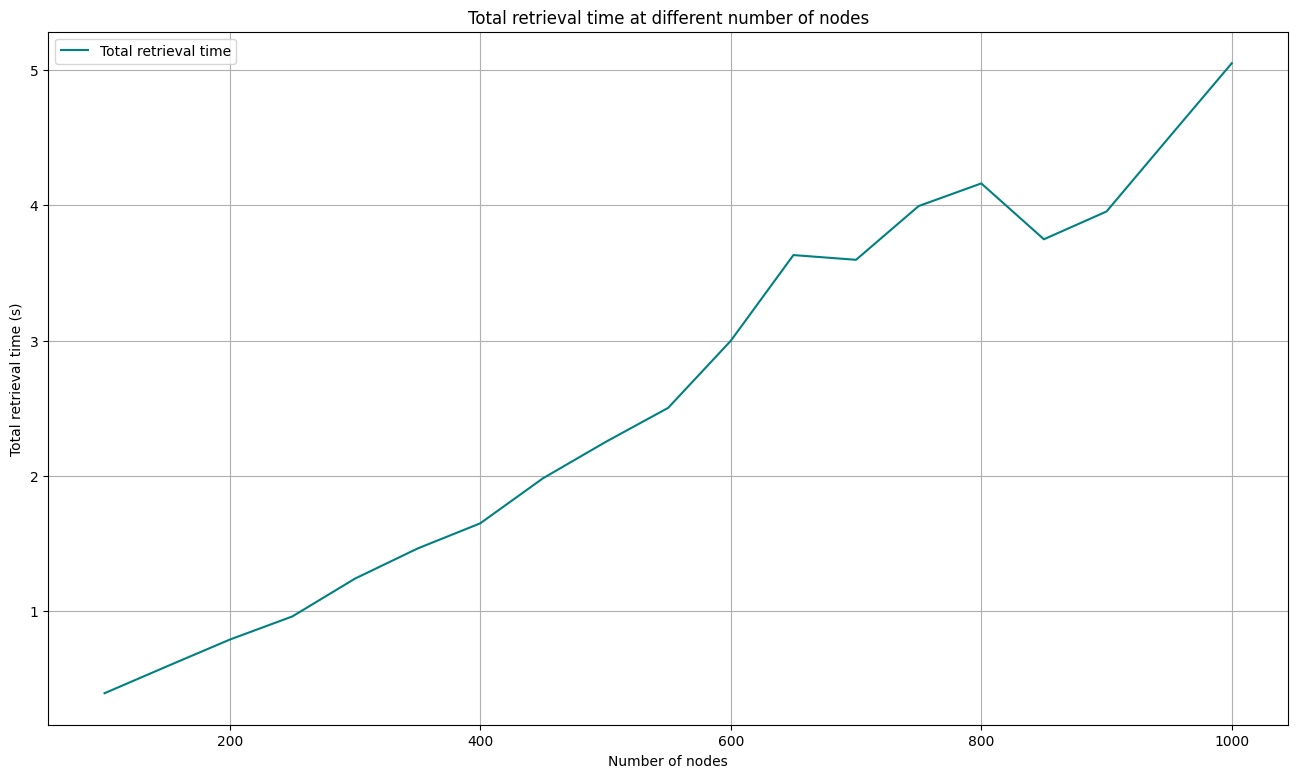

In [81]:
import matplotlib.pyplot as plt
import numpy as np


def measure_total_retrieval_time(num_cids: int) -> float:
    """
    Measure the total retrieval time of chain with number of nodes

    Args:
        num_cids (int): the number of CIDs in a chain

    Returns:
        float: the total retrieval time of the chain
    """
    cids = create_chain_prior_node(num_cids)
    print("Testing retrieval time for %d IPAROs" % num_cids)
    node = cids[-1]

    start = time.time()
    while node != None:
        iparo = get_iparo(node)
        node = iparo["prev_cid"]
    end = time.time()

    return end-start


x = np.arange(100, 1001, 50)
y = []

for num_cids in x:
    y.append(measure_total_retrieval_time(num_cids=num_cids))

# Create a plot
plt.figure(figsize=(16, 9))
plt.title("Total retrieval time at different number of nodes")
plt.plot(x, y, color='teal')
plt.xlabel("Number of nodes")
plt.ylabel("Total retrieval time (s)")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Summary

This notebook demonstrate a simple implementation of IPARO using IPFS. We created, stored, linked and retrieved IPAROs, providing a basic understanding of how to work with decentralized web archiving objects

### Implemented Features:

1. **IPARO Creation**: Defined a function to create IPAROs with content, links to previous IPAROs, and a timestamp.
2. **Storing IPAROs in IPFS**: Developed a function to add IPAROs to IPFS and retrieve their unique content identifiers (CIDs).
3. **Linking IPAROs**: Implemented a function to create a chain where each IPARO links only to the immediately preceding IPARO.
4. **Retrieving and Navigating IPAROs**: Demonstrated how to retrieve IPAROs from IPFS and navigate between linked IPAROs.
5. **Metric Tests**:
   - **Storage Efficiency**: Measured the size of IPAROs and compared it with the original content size.
   - **Retrieval Time**: Measured the time taken to retrieve IPAROs from IPFS.
   - **Scalability**: Evaluated the performance with a large number of IPAROs.